In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [27]:
# Define temperature range
T0 = 273.15
dt = 80

T = np.arange(T0, T0+dt+1, 1)
R = 8.314 # [m^3*Pa/K/mol]

# Define temperature conversion functions
def Kelvin_Celsius(t):
    """
    This function converts Temperature values from Kelvin to degrees Celsius
    """
    return t-273.15

def Celsius_Kelvin(t):
    """
    This function converts Temperature values from degrees Celsius to Kelvin
    """
    return t+273.15

# Load Henry's Law Constants:
DR = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["DR"]
HR = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["HR"]
kh = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["k"]
theta = 1.022 # temperature correction factor

In [4]:
h_r = 30 # height of the reactor [m]
ar = 5 # aspect ratio: height to diameter

r = h_r/(ar * 2)
h = 2/3 * h_r # initial height of broth  assuming it is 2/3 filled [m]
A = math.pi * r**2 #reactor cross-sectional area [m^2]
V_L = A * h #reactor volume [m^3]

p_t = 101325 # pressure at the top of the reactor [Pa]
p_b = p_t + h * 1000 * 9.81 # pressure at the bottom of the reactor [Pa]
p_m = (p_b-p_t)/math.log(p_b/p_t) # logarithmic mean pressure [Pa]

h,r,A,V_L

(20.0, 3.0, 28.274333882308138, 565.4866776461628)

In [5]:
#v_gas = np.arange(0, 0.5, 0.001)

# Kla Temperature correction:
def KLa(C,T,v_gas):
    return 0.32 * (DR[C]/DR["O2"])**0.5 * v_gas**0.7 * theta**(T-293.15)# * 3600 #[1/s]

# Saturation concentration
def Csat(C, T, y):
    return HR[C] * math.e**(kh[C]*(1/T-1/298.15)) * 10**(-5) * p_m * y

# Combine as transfer rate:
def RT(C,T,v_gas,c,y):
    return KLa(C,T,v_gas) * (Csat(C,T, y) - c)

# Maximum supportable cell concentration

assuming a hydrogen limitation, what is the maximum possible cell consentration in the reactor, as determined by the transfer rate.

Using the disolved hydrogen mass balance:

<div style="text-align: center">  $ \displaystyle \frac{dc_{H_2}}{dt} = q_{H_2} * c_X + R_{H_2} $</div>
    
<p>Including Pirt kinetics, specific consumption and production rate and the mass transfer rate </p>
<br>
<div style="text-align: center">  $ q_i = \displaystyle \frac{µ}{Y_{Xi}} + m_{NGAM,i} $ [$h^{-1}$]</div>
<br>
<div style="text-align: center">  $ m_{NGAM,i} = \displaystyle \frac{m_{NGAM}}{-\Delta _r G^T * Y_{PS,cata}}$ [$h^{-1}$]</div>
<p> Transfer rate for compound i: </p>
<div style="text-align: center">  $ R_{T,i} = k_La_{T,i}*(c^*_{T,i} - c_{l,i}) $ [$mol/m^3/s$]</div>
<br>
    
<div style="text-align: center"> $ \displaystyle \frac{dc_{H_2}}{dt} = (\frac{\mu}{Y_{X,H_2}} + \frac{m_{NGAM}}{-\Delta _r G^T * Y_{PS,cata}}) * c_x +  k_La_{T,H_2}*(c^*_{T,H_2} - c_{l,H_2})$ <div>

We are interested in finding c_x at the steady state condition where, with a maximum transfer rate, all substrate is used for maintenance, leaving nothing for additional growth. Thus $ \frac{dc_{H_2}}{dt} = 0 $,  µ = 0, $c_{l,H_2} = 0$

<div style="text-align: center"> $ \displaystyle 0 = \frac{m_{NGAM}}{-\Delta _r G^T * Y_{PS,cata}} * c_x +  k_La_{T,H_2} * c^*_{T,H_2}$ <div><br>


<div style="text-align: center"> $ \displaystyle c_x  = \frac {k_La_{T,H_2}*c^*_{T,H_2}*\Delta _r G^T * Y_{PS,cata}}{m_{NGAM}}$ <div>


In [72]:
# Load the thermodynamic data of the compounds
dfGR = pd.read_csv("../Data/EnthalpyGibbs.csv", index_col="Compound")["dfGR"]
dfHR = pd.read_csv("../Data/EnthalpyGibbs.csv", index_col="Compound")["dfHR"]

# Calculate the Gibbs free energy of reaction from the reaction stoichiometry and Gibbs free energy of formation (eq.24), here as vector multiplication.
DrGR = np.nansum(S.Cata * dfGR)

# Calculate the Enthalpy of reaction from the reaction stoichiometry and Enthalpy of the compounds (eq.25)
DrHR = np.nansum(S.Cata * dfHR)

#Gibbs–Helmholtz equation for temperature correction (eq.26)
def DrGT(T):
    return DrGR * (T/298.15) + DrHR * (1-T/298.15)

def m_NGAM(T):
    """
    This function is the Arrhenius equation, as fit by Tijsen et al.
    """
    return 3.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]

print("m_NGAM(300) =", round(m_NGAM(300),2), "[kJ/h/CmolX]")

m_NGAM(300) = 1.25 [kJ/h/CmolX]


In [40]:
KLa("H2",Celsius_Kelvin(60),0.5)/(m_NGAM(Celsius_Kelvin(60))/(DrGT(Celsius_Kelvin(60))*(-1/4)))

0.7251369114731472

7.007129580386928


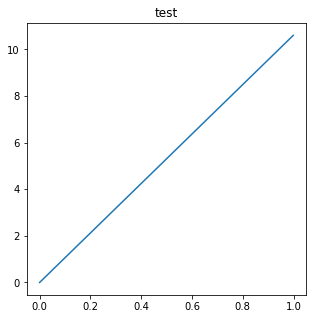

In [55]:
def c_xmax(T,c_Gas,v_gas):
    return KLa("H2",T,v_gas) * HR["H2"] * math.e**(kh["H2"]*(1/T-1/298.15)) * 10**(-5) * p_m * y * DrGT(T)*(-1/4)/m_NGAM(T)

print(c_xmax(Celsius_Kelvin(30),0.66,0.5))

y = np.arange(0,1,0.001)

fig = plt.figure(figsize=(5,5))
plt.title(f"test")
plt.plot(y,c_xmax(Celsius_Kelvin(30),y,0.5))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

b = np.arange(0, 0.5, 0.001)
d = np.arange(0, 100, 0.1)

B, D = np.meshgrid(T, d)
KLa_mesh = (DR["H2"]/DR["O2"])**0.5 *0.042 * B**0.82*(5.38*10**(-5)*D+0.00062)**(-0.39)*theta**(T-293.15)
#v_gas_mesh = b**2.564*(5.38*10**(-5)*b+0.00062) * m_NGAM(T)/(math.sqrt(DR.H2/DR.O2)*0.042*theta**(T-293.15)*DrGT(T)*(-1/4))

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(B, D, KLa_mesh)
plt.xlabel('b')
plt.ylabel('d')
plt.show()

plt.contourf(B, D, KLa_mesh)
plt.colorbar()
plt.xlabel('v_gas [m/s]')
plt.ylabel('c_x [gDW/l]')
plt.show()

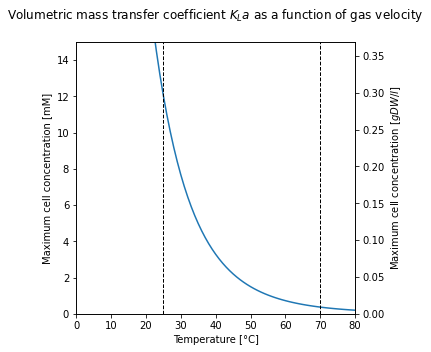

In [39]:
fig = plt.figure(figsize=(5,5))
plt.title(f"Volumetric mass transfer coefficient $K_La$ as a function of gas velocity \n")
plt.plot(Kelvin_Celsius(T), KLa("H2",T,0.5)/(m_NGAM(T)/(DrGT(T)*(-1/4))))
plt.axis([Kelvin_Celsius(T0), Kelvin_Celsius(T0)+dt, 0, 15])
plt.axvline(x = 25, color = 'black', linestyle = '--', linewidth = 1)
plt.axvline(x = 70, color = 'black', linestyle = '--', linewidth = 1)
plt.xlabel('Temperature [°C]')
plt.ylabel('Maximum cell concentration [mM]')

ax2 = plt.twinx()
ax2.set_ylabel(r'Maximum cell concentration [$gDW/l$]')
ax2.axis([Kelvin_Celsius(T0), Kelvin_Celsius(T0)+dt, 0, 15*24.6/1000])
plt.show()

plt.show()

In [42]:
KLa("H2",Celsius_Kelvin(30),0.5)/(m_NGAM(Celsius_Kelvin(30))/(DrGT(Celsius_Kelvin(30))*(-1/4)))

7.68240739359845

In [58]:
HR

Compound
CO      0.99
CO2    35.00
H2      0.78
O2      1.30
N2      0.60
Name: HR, dtype: float64

In [70]:
T = Celsius_Kelvin(60)

math.sqrt(DR.H2/DR.O2)*0.32*0.5**0.7*theta**(T-293.15)*HR.H2*math.e**(1/T-1/296.15)*R*T/m_NGAM(T)

44.54005469286444

In [71]:
m_NGAM(T)

33.388141837745856

44613.28990638946


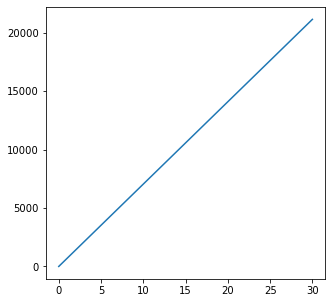

In [61]:
def c_xmax(T,c_Gas,v_gas):
    return math.sqrt(DR.H2/DR.O2)*0.32*v_gas**0.7*theta**(T-293.15)*HR.H2*math.e**(1/T-1/296.15)*c_Gas*R*T

print(c_xmax(Celsius_Kelvin(60),30,0.5))

y = np.arange(0,30,0.01)

fig = plt.figure(figsize=(5,5))
#plt.title(f"test")
plt.plot(y,c_xmax(Celsius_Kelvin(30),y,0.5))